<a href="https://colab.research.google.com/github/m0zzarella/Fundus-Imaging/blob/main/Classification_of_ARMD_and_Normal_FIs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
 # Import the necessary libraries
import os
from PIL import Image
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import numpy as np
import cv2
from skimage import io
from skimage.filters import threshold_otsu
from skimage.morphology import opening
from skimage.filters import gaussian
from skimage.filters import difference_of_gaussians
from skimage.morphology import dilation
from skimage.transform import hough_circle
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.feature import peak_local_max
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#OD Detection

def circle_brightest_part(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Blur the image to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Find the coordinates of the brightest pixel in the image
    minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(blurred)

    # Draw a circle centered at the coordinates of the brightest pixel
    brightest_part = cv2.circle(image, maxLoc, 30, (255, 0, 0), 2)

    return brightest_part, list(maxLoc)


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [34]:
img_src = "/content/drive/MyDrive/ARMD_flipped/Aria_Normal"
resized_dst = "/content/drive/MyDrive/ARMD_flipped/Aria_Normal_flipped"
width = 300


# Loop through all the files in the source folder
for filename in os.listdir(img_src):
    #print(filename)

    print(f"Processing {filename} from {img_src}...")
    
    # Load the image and convert it to grayscale
    image = io.imread(img_src + "/" + filename)
  

    img_save = image.copy()
    
    # Get the coordinates of the optic disc
    od_marked, loc = circle_brightest_part(image)
    x = loc[0]
    # If the optic disc is on the right side
    if x > width // 2:
        # Flip the image horizontally
        img_save = cv2.flip(img_save, 1)
    io.imsave(resized_dst + "/" + filename, img_save)
print("ALL DONE!")

Processing aria_c_9_6.png from /content/drive/MyDrive/ARMD_flipped/Aria_Normal...
Processing aria_c_7_2.png from /content/drive/MyDrive/ARMD_flipped/Aria_Normal...
Processing aria_c_5_1.png from /content/drive/MyDrive/ARMD_flipped/Aria_Normal...
Processing aria_c_4_ 1.png from /content/drive/MyDrive/ARMD_flipped/Aria_Normal...
Processing aria_c_5_ 4.png from /content/drive/MyDrive/ARMD_flipped/Aria_Normal...
Processing aria_c_4_ 8.png from /content/drive/MyDrive/ARMD_flipped/Aria_Normal...
Processing aria_c_6_ 5.png from /content/drive/MyDrive/ARMD_flipped/Aria_Normal...
Processing aria_c_47_2.png from /content/drive/MyDrive/ARMD_flipped/Aria_Normal...
Processing aria_c_46_12.png from /content/drive/MyDrive/ARMD_flipped/Aria_Normal...
Processing aria_c_45_2.png from /content/drive/MyDrive/ARMD_flipped/Aria_Normal...
Processing aria_c_47_15.png from /content/drive/MyDrive/ARMD_flipped/Aria_Normal...
Processing aria_c_6_ 2.png from /content/drive/MyDrive/ARMD_flipped/Aria_Normal...
Proce

In [35]:
img_src = "/content/drive/MyDrive/ARMD_flipped/Aria_ARMD"
resized_dst = "/content/drive/MyDrive/ARMD_flipped/Aria_ARMD_flipped"
width = 300


# Loop through all the files in the source folder
for filename in os.listdir(img_src):
    #print(filename)

    print(f"Processing {filename} from {img_src}...")
    
    # Load the image and convert it to grayscale
    image = io.imread(img_src + "/" + filename)
  

    img_save = image.copy()
    
    # Get the coordinates of the optic disc
    od_marked, loc = circle_brightest_part(image)
    x = loc[0]
    # If the optic disc is on the right side
    if x > width // 2:
        # Flip the image horizontally
        img_save = cv2.flip(img_save, 1)
    io.imsave(resized_dst + "/" + filename, img_save)
print("ALL DONE!")

Processing aria_a_11_6.png from /content/drive/MyDrive/ARMD_flipped/Aria_ARMD...
Processing aria_a_10_27.png from /content/drive/MyDrive/ARMD_flipped/Aria_ARMD...
Processing aria_a_26_10.png from /content/drive/MyDrive/ARMD_flipped/Aria_ARMD...
Processing aria_a_20_6.png from /content/drive/MyDrive/ARMD_flipped/Aria_ARMD...
Processing aria_a_11_30.png from /content/drive/MyDrive/ARMD_flipped/Aria_ARMD...
Processing aria_a_15_35.png from /content/drive/MyDrive/ARMD_flipped/Aria_ARMD...
Processing aria_a_12_34.png from /content/drive/MyDrive/ARMD_flipped/Aria_ARMD...
Processing aria_a_13_2.png from /content/drive/MyDrive/ARMD_flipped/Aria_ARMD...
Processing aria_a_14_19.png from /content/drive/MyDrive/ARMD_flipped/Aria_ARMD...
Processing aria_a_12_15.png from /content/drive/MyDrive/ARMD_flipped/Aria_ARMD...
Processing aria_a_13_22.png from /content/drive/MyDrive/ARMD_flipped/Aria_ARMD...
Processing aria_a_18_23.png from /content/drive/MyDrive/ARMD_flipped/Aria_ARMD...
Processing aria_a_1

## Full image -- process:

In [71]:
data_path = "/content/drive/MyDrive/ARMD_dataset_all"
data = []
labels = []
count = 0
for img_file in tqdm(os.listdir(data_path)):
    img = cv2.imread(os.path.join(data_path, img_file), cv2.IMREAD_GRAYSCALE)
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    hist_norm = cv2.normalize(hist, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    data.append(hist_norm.flatten())
    if img_file[0] == '0':
        labels.append(0)
        count += 1
    else:
        labels.append(1)
X_train = data
X_test = test_data
test_data_path = "/content/drive/MyDrive/Aria_Test_Dataset_Resized"

test_data = []
test_labels = []
test_count = 0
for img_file in tqdm(os.listdir(test_data_path)):
    img = cv2.imread(os.path.join(data_path, img_file), cv2.IMREAD_GRAYSCALE)
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    hist_norm = cv2.normalize(hist, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    test_data.append(hist_norm.flatten())
    if img_file[0] == '0':
        test_labels.append(0)
        test_count += 1
    else:
        test_labels.append(1)
y_test = test_labels
y_train = labels
X_train = data
X_test = test_data

#X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.000001, random_state=786)

100%|██████████| 84/84 [00:00<00:00, 407.61it/s]


In [72]:
print("Length of:")
print(f"X_train = {len(X_train)}")
print(f"X_test = {len(X_test)}")
print(f"y_train = {len(y_train)}")
print(f"y_test = {len(y_test)}")
print(f"---No. of Class 0 (ARMD) samples = {count + test_count}---")
print(f"---No. of Class 1 (Normal) samples = {559 - (count+test_count)}---")

Length of:
X_train = 475
X_test = 84
y_train = 475
y_test = 84
---No. of Class 0 (ARMD) samples = 261---
---No. of Class 1 (Normal) samples = 298---


# Full image -- training:

In [ ]:
#Model Metrics
import numpy as np
import tensorflow as tf
from keras import backend as K
'''
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
'''
import numpy as np



In [73]:
# Train an SVM classifier on the training set
clf = SVC(kernel="linear")
clf.fit(X_train, y_train)

# Evaluate the classifier on the testing set
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred) 


# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Accuracy: {acc:.2f}, Precision: {prec:.2f}, Recall: {rec:.2f}, F1 Score: {f1:.2f}")


Sensitivity: 1.00
Specificity: 0.43
Accuracy: 0.85, Precision: 0.82, Recall: 1.00, F1 Score: 0.90


## Block-wise processing:

In [49]:
'''
# Load the dataset and labels
data_path = "/content/drive/MyDrive/ARMD_dataset_all"
left, right, center = [], [], []
labels = []
radius = 50
num_blocks = 3

for img_file in os.listdir(data_path):
    #print(img_file)
    img = io.imread(data_path + "/" + img_file)
    #cv2.imread(os.path.join(data_path, img_file), cv2.IMREAD_GRAYSCALE)
    img_od = img.copy()
    
    od_marked, loc = circle_brightest_part(img_od)
    x, y = loc[0], loc[1]
    x1 = int(y - radius) # y-coordinate of the OD - 50
    x2 = int(y + radius) # y-coordinate of the OD + 50
    middle_strip = img[x1 : x2, :]
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #vertical strips
    blocks = [middle_strip[ : , i * (radius * 2) : (i + 1) * (radius * 2)] for i in range(3)]

    for i, block in enumerate(blocks):
        hist = cv2.calcHist([block], [0], None, [256], [0, 256])
        hist_norm = cv2.normalize(hist, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
        if i == 0:
            left.append(hist_norm.flatten())
        elif i == 1:
            center.append(hist_norm.flatten())
        else:
            right.append(hist_norm.flatten())

    if img_file[0] == '0':
        labels.append(0)
        
    else:
        labels.append(1)
        
data = [left, center, right]
data = np.array(data)

# Reshape data to have the shape (num_samples, 3*256)
data = np.reshape(data, (data.shape[1], -1))


# Split the dataset into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=786)'''

In [87]:
data_path = "/content/drive/MyDrive/ARMD_dataset_all"
test_data_path = "/content/drive/MyDrive/Aria_Test_Dataset_Resized"
left, right, center = [], [], []
test_left, test_right, test_center = [], [], []
data = []
test_data = []

labels = []
test_labels = []
count = 0
test_count = 0
for img_file in tqdm(os.listdir(data_path)):
    img = cv2.imread(os.path.join(data_path, img_file), cv2.IMREAD_UNCHANGED)
    #cv2.imread(os.path.join(data_path, img_file), cv2.IMREAD_GRAYSCALE)
    img_od = img.copy()
    
    od_marked, loc = circle_brightest_part(img_od)
    x, y = loc[0], loc[1]
    x1 = int(y - radius) # y-coordinate of the OD - 50
    x2 = int(y + radius) # y-coordinate of the OD + 50
    middle_strip = img[x1 : x2, :]
    '''
    height, width = img.shape
    strip_height = height // 3
    middle_strip = img[strip_height:2*strip_height, :]
    '''
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #vertical strips
    blocks = [middle_strip[ : , i * (radius * 2) : (i + 1) * (radius * 2)] for i in range(3)]

    for i, block in enumerate(blocks):
        hist = cv2.calcHist([block], [0], None, [256], [0, 256])
        hist_norm = cv2.normalize(hist, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
        if i == 0:
            left.append(hist_norm.flatten())
        elif i == 1:
            center.append(hist_norm.flatten())
        else:
            right.append(hist_norm.flatten())

    if img_file[0] == '0':
        labels.append(0)
        count+=1
    else:
        labels.append(1)
        
data = [left, center, right]
data = np.array(data)
data = np.reshape(data, (data.shape[1], -1))

#Test data prep



for img_file in tqdm(os.listdir(test_data_path)):

    img = cv2.imread(os.path.join(test_data_path, img_file), cv2.IMREAD_UNCHANGED)
    img_od = img.copy()
    
    od_marked, loc = circle_brightest_part(img_od)
    x, y = loc[0], loc[1]
    x1 = int(y - radius) # y-coordinate of the OD - 50
    x2 = int(y + radius) # y-coordinate of the OD + 50
    '''
    height, width = img.shape
    strip_height = height // 3
    middle_strip = img[strip_height:2*strip_height, :]
    '''
    middle_strip = img[x1 : x2, :]
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #vertical strips
    blocks = [middle_strip[ : , i * (radius * 2) : (i + 1) * (radius * 2)] for i in range(3)]

    for i, block in enumerate(blocks):
        hist = cv2.calcHist([block], [0], None, [256], [0, 256])
        hist_norm = cv2.normalize(hist, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
        if i == 0:
            test_left.append(hist_norm.flatten())
        elif i == 1:
            test_center.append(hist_norm.flatten())
        else:
            test_right.append(hist_norm.flatten())

    if img_file[0] == '0':
        test_labels.append(0)
        test_count+=1
    else:
        test_labels.append(1)
test_data = [test_left, test_center, test_right]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (test_data.shape[1], -1))

y_test = test_labels
y_train = labels
X_train = data
X_test = test_data

100%|██████████| 84/84 [00:00<00:00, 123.13it/s]


In [88]:
print("Length of:")
print(f"X_train = {len(X_train)}")
print(f"X_test = {len(X_test)}")
print(f"y_train = {len(y_train)}")
print(f"y_test = {len(y_test)}")

Length of:
X_train = 475
X_test = 84
y_train = 475
y_test = 84


  0%|          | 0/475 [00:00<?, ?it/s]


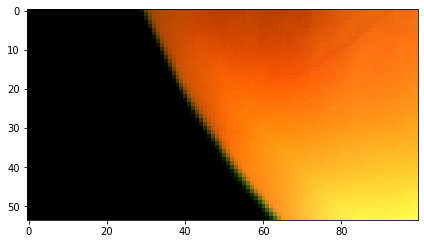

In [89]:
for img_file in tqdm(os.listdir(data_path)):
    img = io.imread(data_path + "/" + img_file)
    #cv2.imread(os.path.join(data_path, img_file), cv2.IMREAD_GRAYSCALE)
    img_od = img.copy()
    
    od_marked, loc = circle_brightest_part(img_od)
    x, y = loc[0], loc[1]
    radius = 50
    x1 = int(y - radius) # y-coordinate of the OD - 50
    x2 = int(y + radius) # y-coordinate of the OD + 50
    middle_strip = img[x1 : x2, :]
    blocks = [middle_strip[ : , i * (radius * 2) : (i + 1) * (radius * 2)] for i in range(3)]

    break
io.imshow(blocks[0])

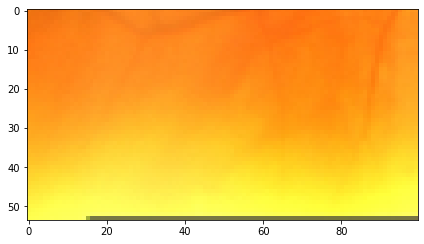

In [90]:
io.imshow(blocks[1])

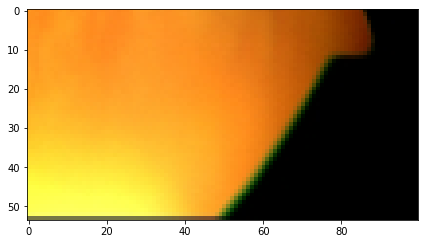

In [91]:
io.imshow(blocks[2])

# Blocks - Left, Right, Center

In [92]:
# Train an SVM classifier on the training set
clf = SVC(kernel="linear")
clf.fit(X_train, y_train)

# Evaluate the classifier on the testing set
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Accuracy: {acc:.2f}, Precision: {prec:.2f}, Recall: {rec:.2f}, F1 Score: {f1:.2f}")

Sensitivity: 0.21
Specificity: 0.74
Accuracy: 0.36, Precision: 0.68, Recall: 0.21, F1 Score: 0.33


# Middle Strip:

In [95]:
# Load the dataset and labels
data_path = "/content/drive/MyDrive/ARMD_dataset_all"
test_data_path = "/content/drive/MyDrive/Aria_Test_Dataset_Resized"
data = []
test_data = []
labels = []
test_labels = []
radius = 50
num_blocks = 3

for img_file in tqdm(os.listdir(data_path)):
    img = io.imread(data_path + "/" + img_file)
    #cv2.imread(os.path.join(data_path, img_file), cv2.IMREAD_GRAYSCALE)
    img_od = img.copy()
    
    od_marked, loc = circle_brightest_part(img_od)
    x, y = loc[0], loc[1]
    x1 = int(y - radius) # y-coordinate of the OD - 50
    x2 = int(y + radius) # y-coordinate of the OD + 50
    middle_strip = img[x1 : x2, :]
    
    hist = cv2.calcHist([middle_strip], [0], None, [256], [0, 256])
    hist_norm = cv2.normalize(hist, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    data.append(hist_norm.flatten())
    if img_file[0] == '0':
        labels.append(0)
    else:
        labels.append(1)

#test_data

for img_file in tqdm(os.listdir(test_data_path)):
    img = io.imread(test_data_path + "/" + img_file)
    #cv2.imread(os.path.join(data_path, img_file), cv2.IMREAD_GRAYSCALE)
    img_od = img.copy()
    
    od_marked, loc = circle_brightest_part(img_od)
    x, y = loc[0], loc[1]
    x1 = int(y - radius) # y-coordinate of the OD - 50
    x2 = int(y + radius) # y-coordinate of the OD + 50
    middle_strip = img[x1 : x2, :]
    
    hist = cv2.calcHist([middle_strip], [0], None, [256], [0, 256])
    hist_norm = cv2.normalize(hist, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    test_data.append(hist_norm.flatten())
    if img_file[0] == '0':
        test_labels.append(0)
    else:
        test_labels.append(1)

y_test = test_labels
y_train = labels
X_train = data
X_test = test_data



# Split the dataset into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=786)

100%|██████████| 84/84 [00:00<00:00, 106.71it/s]


In [96]:
print("Length of:")
print(f"X_train = {len(X_train)}")
print(f"X_test = {len(X_test)}")
print(f"y_train = {len(y_train)}")
print(f"y_test = {len(y_test)}")

Length of:
X_train = 475
X_test = 84
y_train = 475
y_test = 84


In [97]:
# Train an SVM classifier on the training set
clf = SVC(kernel="linear")
clf.fit(X_train, y_train)

# Evaluate the classifier on the testing set
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Accuracy: {acc:.2f}, Precision: {prec:.2f}, Recall: {rec:.2f}, F1 Score: {f1:.2f}")

Sensitivity: 0.46
Specificity: 0.52
Accuracy: 0.48, Precision: 0.72, Recall: 0.46, F1 Score: 0.56


# Parts of blocks

In [112]:
# Load the dataset and labels
data_path = "/content/drive/MyDrive/ARMD_dataset_all"
test_data_path = "/content/drive/MyDrive/Aria_Test_Dataset_Resized"
left, right, center = [], [], []
test_left, test_right, test_center = [], [], []

labels = []
test_labels = []
radius = 50
num_blocks = 3

for img_file in tqdm(os.listdir(data_path)):
    img = io.imread(data_path + "/" + img_file)
    #cv2.imread(os.path.join(data_path, img_file), cv2.IMREAD_GRAYSCALE)
    img_od = img.copy()
    
    od_marked, loc = circle_brightest_part(img_od)
    x, y = loc[0], loc[1]
    x1 = int(y - radius) # y-coordinate of the OD - 50
    x2 = int(y + radius) # y-coordinate of the OD + 50
    middle_strip = img[x1 : x2, :]
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #vertical strips
    blocks = [middle_strip[ : , i * (radius * 2) : (i + 1) * (radius * 2)] for i in range(3)]

    for i, block in enumerate(blocks):
        hist = cv2.calcHist([block], [0], None, [256], [0, 256])
        hist_norm = cv2.normalize(hist, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
        if i == 0:
            left.append(hist_norm.flatten())
        elif i == 1:
            center.append(hist_norm.flatten())
        else:
            right.append(hist_norm.flatten())

    if img_file[0] == '0':
        labels.append(0)
    else:
        labels.append(1)
        
data = [left, center, right]
data = np.array(data)

#test_data


for img_file in tqdm(os.listdir(test_data_path)):
    img = io.imread(test_data_path + "/" + img_file)
    #cv2.imread(os.path.join(data_path, img_file), cv2.IMREAD_GRAYSCALE)
    img_od = img.copy()
    
    od_marked, loc = circle_brightest_part(img_od)
    x, y = loc[0], loc[1]
    x1 = int(y - radius) # y-coordinate of the OD - 50
    x2 = int(y + radius) # y-coordinate of the OD + 50
    middle_strip = img[x1 : x2, :]
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #vertical strips
    blocks = [middle_strip[ : , i * (radius * 2) : (i + 1) * (radius * 2)] for i in range(3)]

    for i, block in enumerate(blocks):
        hist = cv2.calcHist([block], [0], None, [256], [0, 256])
        hist_norm = cv2.normalize(hist, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
        if i == 0:
            test_left.append(hist_norm.flatten())
        elif i == 1:
            test_center.append(hist_norm.flatten())
        else:
            test_right.append(hist_norm.flatten())

    if img_file[0] == '0':
        test_labels.append(0)
    else:
        test_labels.append(1)
        
test_data = [test_left, test_center, test_right]
test_data = np.array(test_data)

100%|██████████| 84/84 [00:00<00:00, 107.54it/s]


In [113]:
data_left = data[0]
data_center = data[1]
data_right = data[2]

data_left_center = list()
data_left_center.append(data[0])
data_left_center.append(data[1])

data_left_right = list()
data_left_right.append(data[0])
data_left_right.append(data[2])

data_center_right = list()
data_center_right.append(data[1])
data_center_right.append(data[2])


#test

test_data_left = test_data[0]
test_data_center = test_data[1]
test_data_right = test_data[2]

test_data_left_center = list()
test_data_left_center.append(test_data[0])
test_data_left_center.append(test_data[1])

test_data_left_right = list()
test_data_left_right.append(test_data[0])
test_data_left_right.append(test_data[2])

test_data_center_right = list()
test_data_center_right.append(test_data[1])
test_data_center_right.append(test_data[2])

# Left:

In [114]:
# Reshape data to have the shape (num_samples, 3*256)
#data_left = np.reshape(data_left, (data_left.shape[1], -1))

# Split the dataset into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(data_left, labels, test_size=0.2, random_state=786)

y_test = test_labels
y_train = labels
X_train = data_left
X_test = test_data_left

# Train an SVM classifier on the training set
clf = SVC(kernel="linear")
clf.fit(X_train, y_train)

# Evaluate the classifier on the testing set
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Accuracy: {acc:.2f}, Precision: {prec:.2f}, Recall: {rec:.2f}, F1 Score: {f1:.2f}") 


Sensitivity: 0.59
Specificity: 0.39
Accuracy: 0.54, Precision: 0.72, Recall: 0.59, F1 Score: 0.65


# Center:

In [115]:
# Split the dataset into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(data_center, labels, test_size=0.2, random_state=786)

y_test = test_labels
y_train = labels
X_train = data_center
X_test = test_data_center
# Train an SVM classifier on the training set
clf = SVC(kernel="linear")
clf.fit(X_train, y_train)

# Evaluate the classifier on the testing set
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Accuracy: {acc:.2f}, Precision: {prec:.2f}, Recall: {rec:.2f}, F1 Score: {f1:.2f}")

Sensitivity: 0.20
Specificity: 0.78
Accuracy: 0.36, Precision: 0.71, Recall: 0.20, F1 Score: 0.31


# Right:

In [116]:
# Split the dataset into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(data_right, labels, test_size=0.2, random_state=786)
y_test = test_labels
y_train = labels
X_train = data_right
X_test = test_data_right
# Train an SVM classifier on the training set
clf = SVC(kernel="linear")
clf.fit(X_train, y_train)

# Evaluate the classifier on the testing set
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Accuracy: {acc:.2f}, Precision: {prec:.2f}, Recall: {rec:.2f}, F1 Score: {f1:.2f}")

Sensitivity: 0.48
Specificity: 0.17
Accuracy: 0.39, Precision: 0.60, Recall: 0.48, F1 Score: 0.53


# Left-center:

In [117]:
# Reshape data to have the shape (num_samples, 3*256)
data_left_center = np.array(data_left_center)
data_left_center = np.reshape(data_left_center, (data_left_center.shape[1], -1))

test_data_left_center = np.array(test_data_left_center)
test_data_left_center = np.reshape(test_data_left_center, (test_data_left_center.shape[1], -1))

# Split the dataset into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(data_left_center, labels, test_size=0.2, random_state=786)
y_test = test_labels
y_train = labels
X_train = data_left_center
X_test = test_data_left_center
# Train an SVM classifier on the training set
clf = SVC(kernel="linear")
clf.fit(X_train, y_train)
# Evaluate the classifier on the testing set
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Accuracy: {acc:.2f}, Precision: {prec:.2f}, Recall: {rec:.2f}, F1 Score: {f1:.2f}")

Sensitivity: 0.48
Specificity: 0.22
Accuracy: 0.40, Precision: 0.62, Recall: 0.48, F1 Score: 0.54


In [ ]:
x = list()
x.append([1,2,3])
x.append([1,2,3])
x

[[1, 2, 3], [1, 2, 3]]

# Left-right:

In [118]:
# Reshape data to have the shape (num_samples, 3*256)
data_left_right = np.array(data_left_right)
data_left_right = np.reshape(data_left_right, (data_left_right.shape[1], -1))

test_data_left_right = np.array(test_data_left_right)
test_data_left_right = np.reshape(test_data_left_right, (test_data_left_right.shape[1], -1))

# Split the dataset into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(data_left_right, labels, test_size=0.2, random_state=786)

y_test = test_labels
y_train = labels
X_train = data_left_right
X_test = test_data_left_right
# Train an SVM classifier on the training set
clf = SVC(kernel="linear")
clf.fit(X_train, y_train)

# Evaluate the classifier on the testing set
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Accuracy: {acc:.2f}, Precision: {prec:.2f}, Recall: {rec:.2f}, F1 Score: {f1:.2f}")

Sensitivity: 0.54
Specificity: 0.35
Accuracy: 0.49, Precision: 0.69, Recall: 0.54, F1 Score: 0.61


# Center-right:

In [119]:
# Reshape data to have the shape (num_samples, 3*256)
data_center_right = np.array(data_center_right)
data_center_right = np.reshape(data_center_right, (data_center_right.shape[1], -1))

test_data_center_right = np.array(test_data_center_right)
test_data_center_right = np.reshape(test_data_center_right, (test_data_center_right.shape[1], -1))
# Split the dataset into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(data_center_right, labels, test_size=0.2, random_state=786)
y_test = test_labels
y_train = labels
X_train = data_center_right
X_test = test_data_center_right
# Train an SVM classifier on the training set
clf = SVC(kernel="linear")
clf.fit(X_train, y_train)

# Evaluate the classifier on the testing set
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Accuracy: {acc:.2f}, Precision: {prec:.2f}, Recall: {rec:.2f}, F1 Score: {f1:.2f}")

Sensitivity: 0.51
Specificity: 0.39
Accuracy: 0.48, Precision: 0.69, Recall: 0.51, F1 Score: 0.58


In [120]:
index = ['Left', 'Center', 'Right', 'Left-Center', 'Left-Right', 'Center-Right', 'Left-Center-Right', 'Middle-strip', 'Full-Image']

In [121]:
accu = []
pre = []
recall = []
f1_ = []

In [122]:
accu.append(0.90)
pre.append(0.89)
recall.append(0.81)
f1_.append(0.85)

In [123]:
result = {'Accuracy' : accu,
         'Precision' : pre,
         'Recall' : recall,
         'F1-score' : f1_}

In [124]:
import pandas as pd
result_df = pd.DataFrame(result)

In [125]:
result_df.set_index(pd.Index(index), inplace=True)

ValueError: ignored

In [126]:
result_df

,Accuracy,Precision,Recall,F1-score
0,0.9,0.89,0.81,0.85


Problem statement, 1-page summary, Result, methodology 

In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 10 fold cross validation:

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import numpy as np
import xgboost as xgb

def cross_validate(X, y, model):
    # Create a KFold object with 10 folds
    kf = KFold(n_splits = 10, shuffle = True, random_state = 786)

    sensitivities = []
    specificities = []
    f1_scores = []
    precisions = []
    recalls = []
    accuracies = []

    # Iterate over the folds
    for train_index, test_index in kf.split(X):
        # Split the data into training and test sets for this fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train your model on the training set
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)

        # Calculate the confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        # Calculate sensitivity and specificity for this fold
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Calculate F1-score, precision, recall, and accuracy for this fold
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)

        # Add the metrics to their respective lists
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        f1_scores.append(f1)
        precisions.append(precision)
        recalls.append(recall)
        accuracies.append(accuracy)

    # Calculate the mean metrics over all folds
    mean_sensitivity = round(np.mean(sensitivities), 2)
    mean_specificity = round(np.mean(specificities), 2)
    mean_f1_score = round(np.mean(f1_scores), 2)
    mean_precision = round(np.mean(precisions), 2)
    mean_recall = round(np.mean(recalls), 2)
    mean_accuracy = round(np.mean(accuracies), 2)

    return {'Sensitivity': mean_sensitivity, 
            'Specificity' : mean_specificity,
            'F1-score' : mean_f1_score, 
            'Precision' : mean_precision, 
            'Recall' : mean_recall,
            'Accuracy' : mean_accuracy}


## Center-Right:

In [ ]:
data_center_right = np.array(data_center_right)
#data_center_right = np.reshape(data_center_right, (data_center_right.shape[1], -1))
data_center_right = data_center_right.T
labels = np.array(labels)

model_svm = SVC(kernel='rbf', C=1, gamma='scale')
model_xg = xgb.XGBClassifier(objective="binary:logistic", random_state=786)

result_center_right_svm = cross_validate(data_center_right, labels, model_svm)
result_center_right_xg = cross_validate(data_center_right, labels, model_xg)
print(f"Center-Right -- SVM --\n{result_center_right_svm}")
print(f"Center-Right -- XGBoost --\n{result_center_right_xg}")

IndexError: ignored

## Left-Center:

In [ ]:
data_left_center = np.array(data_left_center)
#data_left_center = np.reshape(data_left_center, (data_left_center.shape[1], -1))
data_left_center = data_left_center.T
labels = np.array(labels)

model_svm = SVC(kernel='rbf', C=1, gamma='scale')
model_xg = xgb.XGBClassifier(objective="binary:logistic", random_state=786)

result_left_center_svm = cross_validate(data_left_center, labels, model_svm)
result_left_center_xg = cross_validate(data_left_center, labels, model_xg)
print(f"Left-Center -- SVM --\n{result_left_center_svm}")
print(f"Left-Center -- XGBoost --\n{result_left_center_xg}")

IndexError: ignored

## Left-Right

In [ ]:
data_left_right = np.array(data_left_right)
data_left_right = data_left_right.T
labels = np.array(labels)

model_svm = SVC(kernel='rbf', C=1, gamma='scale')
model_xg = xgb.XGBClassifier(objective="binary:logistic", random_state=786)

result_left_right_svm = cross_validate(data_left_right, labels, model_svm)
result_left_right_xg = cross_validate(data_left_right, labels, model_xg)

print(f"Left-Right -- SVM --\n{result_left_right_svm}")
print(f"Left-Right -- XGBoost --\n{result_left_right_xg}")


Left-Right -- SVM --
{'Sensitivity': 0.91, 'Specificity': 0.44, 'F1-score': 0.73, 'Precision': 0.62, 'Recall': 0.91, 'Accuracy': 0.68}
Left-Right -- XGBoost --
{'Sensitivity': 0.9, 'Specificity': 0.91, 'F1-score': 0.9, 'Precision': 0.91, 'Recall': 0.9, 'Accuracy': 0.91}


## Left-Right-Center

In [ ]:
data = np.array(data) #Run the cell for getting the full image
data = data.T
labels = np.array(labels)

model_svm = SVC(kernel='rbf', C=1, gamma='scale')
model_xg = xgb.XGBClassifier(objective="binary:logistic", random_state=786)

result_svm = cross_validate(data, labels, model_svm)
result_xg = cross_validate(data, labels, model_xg)
print(f"Left-right-center -- SVM --\n{result_svm}")
print(f"Left-right-center -- XGBoost --\n{result_xg}")

Left-right-center -- SVM --
{'Sensitivity': 0.72, 'Specificity': 0.61, 'F1-score': 0.67, 'Precision': 0.65, 'Recall': 0.72, 'Accuracy': 0.65}
Left-right-center -- XGBoost --
{'Sensitivity': 0.8, 'Specificity': 0.83, 'F1-score': 0.8, 'Precision': 0.82, 'Recall': 0.8, 'Accuracy': 0.82}


## Full Image

In [ ]:
data = np.array(data) #Run the cell for getting the full image
data = data.T
labels = np.array(labels)

model_svm = SVC(kernel='rbf', C=1, gamma='scale')
model_xg = xgb.XGBClassifier(objective="binary:logistic", random_state=786)

result_svm = cross_validate(data, labels, model_svm)
result_xg = cross_validate(data, labels, model_xg)
print(f"Full image -- SVM --\n{result_svm}")
print(f"Full Image -- XGBoost --\n{result_xg}")


Full image -- SVM --
{'Sensitivity': 0.86, 'Specificity': 0.76, 'F1-score': 0.82, 'Precision': 0.78, 'Recall': 0.86, 'Accuracy': 0.81}
Full Image -- XGBoost --
{'Sensitivity': 0.85, 'Specificity': 0.82, 'F1-score': 0.84, 'Precision': 0.83, 'Recall': 0.85, 'Accuracy': 0.84}


## Middle-strip

In [ ]:
data = np.array(data) #Run the cell for getting the middle-strip 
data = data.T
labels = np.array(labels)

model_svm = SVC(kernel='rbf', C=1, gamma='scale')
model_xg = xgb.XGBClassifier(objective="binary:logistic", random_state=786)

result_svm = cross_validate(data, labels, model_svm)
result_xg = cross_validate(data, labels, model_xg)
print(f"Middle-strip -- SVM --\n{result_svm}")
print(f"Middle-strip -- XGBoost --\n{result_xg}")


ValueError: ignored

## Left

In [ ]:
data_left = np.array(data_left)
data_left = data_left.T
labels = np.array(labels)

model_svm = SVC(kernel='rbf', C=1, gamma='scale')
model_xg = xgb.XGBClassifier(objective="binary:logistic", random_state=786)

result_left_svm = cross_validate(data_left, labels, model_svm)
result_left_xg = cross_validate(data_left, labels, model_xg)
print(f"Left -- SVM --\t{result_left_svm}")
print(f"Left -- XGBoost --\t{result_left_xg}")

Left -- SVM --	{'Sensitivity': 0.95, 'Specificity': 0.43, 'F1-score': 0.74, 'Precision': 0.62, 'Recall': 0.95, 'Accuracy': 0.68}
Left -- XGBoost --	{'Sensitivity': 0.79, 'Specificity': 0.74, 'F1-score': 0.76, 'Precision': 0.75, 'Recall': 0.79, 'Accuracy': 0.76}


## Right

In [ ]:
data_right = np.array(data_right)
data_right = data_right.T
labels = np.array(labels)

model_svm = SVC(kernel='rbf', C=1, gamma='scale')
model_xg = xgb.XGBClassifier(objective="binary:logistic", random_state=786)

result_right_svm = cross_validate(data_right, labels, model_svm)
result_right_xg = cross_validate(data_right, labels, model_xg)
print(f"Right -- SVM --\t{result_right_svm}")
print(f"Right -- XGBoost --\t{result_right_xg}")

Right -- SVM --	{'Sensitivity': 0.86, 'Specificity': 0.45, 'F1-score': 0.69, 'Precision': 0.62, 'Recall': 0.86, 'Accuracy': 0.64}
Right -- XGBoost --	{'Sensitivity': 0.81, 'Specificity': 0.78, 'F1-score': 0.79, 'Precision': 0.78, 'Recall': 0.81, 'Accuracy': 0.79}


## Center

In [ ]:
data_center = np.array(data_center)
data_center = data_center.T
labels = np.array(labels)

model_svm = SVC(kernel='rbf', C=1, gamma='scale')
model_xg = xgb.XGBClassifier(objective="binary:logistic", random_state=786)

result_center_svm = cross_validate(data_center, labels, model_svm)
result_center_xg = cross_validate(data_center, labels, model_xg)
print(f"Center -- SVM --\t{result_center_svm}")
print(f"Center -- XGBoost --\t{result_center_xg}")

Center -- SVM --	{'Sensitivity': 0.59, 'Specificity': 0.59, 'F1-score': 0.56, 'Precision': 0.6, 'Recall': 0.59, 'Accuracy': 0.57}
Center -- XGBoost --	{'Sensitivity': 0.67, 'Specificity': 0.71, 'F1-score': 0.67, 'Precision': 0.69, 'Recall': 0.67, 'Accuracy': 0.68}
